# ex-51 Australia Spatial GEV Pattern

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd 
import xarray as xr
import rioxarray as rx
import geopandas as gpd
import matplotlib.pyplot as plt
from temporal_curve import temporal_curve_24hr
from temporal_curve import _interp_missing as smooth_durs
%matplotlib inline

# Read GEV data

In [2]:
# gev_file = "data/Global_Extreme_Precipitation_pattern.nc4(only ssp245&585).nc"
gev_file = "data/CMIP6_EP_ensemble_patterns+.nc4"
da_ptn_100a = xr.open_dataset(gev_file)['pattern'].rename({"lat": "latitude", "lon":"longitude"})
da_ptn_100a.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'pattern' (ari: 12, hrs: 11, pth: 9, latitude: 360,
                             longitude: 720)>
[307929600 values with dtype=float32]
Coordinates:
  * ari          (ari) int64 2 3 5 10 15 25 50 100 150 200 300 500
  * hrs          (hrs) int64 3 6 12 24 48 72 96 120 144 168 240
  * latitude     (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * longitude    (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * pth          (pth) float64 1.0 5.0 15.9 25.0 50.0 75.0 84.1 95.0 99.0
    spatial_ref  int32 0
Attributes:
    regenerate:  http://www.climsystems.com J.Yu 2022-05-14

# Process GEV

processing Climate Zone: 1, Pilbara 


hrs,3,6,12,24,48,72,96,120,144,240
2,12.111490,12.154182,12.196876,12.239572,12.282269,12.307246,12.324967,12.338715,12.349946,12.381415
3,12.927890,12.950195,12.972501,12.994806,13.017113,13.030162,13.039420,13.046601,13.052468,13.068909
5,14.065969,14.058452,14.050933,14.043415,14.035897,14.031500,14.028379,14.025960,14.023982,14.018442
10,16.030514,15.986809,15.943105,15.899403,15.855702,15.830141,15.812004,15.797937,15.786444,15.754241
15,17.515831,17.481964,17.448101,17.414238,17.380375,17.360569,17.346516,17.335615,17.326708,17.301756
25,19.707455,19.732147,19.756840,19.781534,19.806229,19.820675,19.830923,19.838875,19.845369,19.863569
50,23.450743,23.621132,23.791548,23.961994,24.132467,24.232201,24.302969,24.357864,24.402719,24.528404
100,28.187120,28.567095,28.947208,29.327461,29.707857,29.930439,30.088392,30.210926,30.311056,30.591648
150,31.611414,32.112965,32.614761,33.116798,33.619080,33.913010,34.121609,34.283440,34.415680,34.786289
200,34.374729,34.959541,35.544682,36.130157,36.715961,37.058788,37.302094,37.490860,37.645115,38.077431


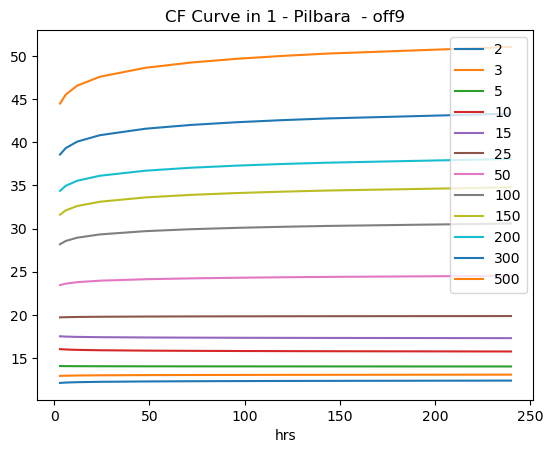

In [7]:
cen_lat = -21.277689
cen_lon = 119.011719

hrs_want = [3, 6, 12, 24, 48, 72, 96, 120, 144, 240]

offset_lat = 9# 5 grids
offset_lon = 13 # 5 grids

ls_cf_cz = []

# extract climate zone (cz) information
cz_id   = 1
cz_name = "Pilbara "
print(f"processing Climate Zone: {cz_id}, {cz_name}")    

# clip climate zone    
da_pth_cz = da_ptn_100a.rio.clip_box(minx=cen_lon-offset_lon,
                                     maxx=cen_lon+offset_lon,
                                     miny=cen_lat-offset_lat,
                                     maxy=cen_lat+offset_lat,
                                    )

# spatial median
da_ptn_cz_m = da_pth_cz.median(dim=['latitude',"longitude"]).drop("spatial_ref")
da_ptn_cz_m = da_ptn_cz_m.sel(hrs=hrs_want)
da_ptn_cz_m.attrs['units'] = "perc/degc"


# smooth durations for each percentile and ari
for iari in np.arange(len(da_ptn_cz_m.ari)):
    for iptl in np.arange(len(da_ptn_cz_m.pth)):
        tmp = smooth_durs(da_ptn_cz_m.hrs * 60, 
                          da_ptn_cz_m[iari,:,iptl] + 1000.0, 
                          da_ptn_cz_m.hrs * 60
                         ) - 1000.0

        da_ptn_cz_m[iari,:,iptl] = tmp[:,0]


# put together
ls_cf_cz.append(da_ptn_cz_m)    



# to dataframe
df_pth_auk = da_ptn_cz_m.sel(pth=95).to_pandas()

# convert duration from hours to minutes
#df_pth_auk.index = np.round(df_pth_auk.index*60, 4)
#df_pth_auk.index.name = "mins"
df_pth_auk.index = da_ptn_100a.ari
df_pth_auk.transpose()

df_pth_auk.transpose().plot() #.drop(168, axis=0)
plt.title(f"CF Curve in {cz_id} - {cz_name} - off{offset_lat}")


df_pth_auk

In [8]:
# save data
da_ptn_cz = xr.concat(ls_cf_cz, dim="CZ")
da_ptn_cz['CZ'] = [cz_name]
da_ptn_cz.to_netcdf("data/AUS_Pilbara_Extreme_Precipitation_Pattern_AR6.nc")

In [9]:
da_ptn_cz

<xarray.DataArray 'pattern' (CZ: 1, ari: 12, hrs: 10, pth: 9)>
array([[[[-5.47928905e+00, -3.05210114e+00, -2.88562268e-01, ...,
           8.83531380e+00,  1.21114902e+01,  1.48339062e+01],
         [-6.15666199e+00, -3.62844086e+00, -7.33162761e-01, ...,
           8.65639973e+00,  1.21541824e+01,  1.50888844e+01],
         [-6.83357382e+00, -4.20444727e+00, -1.17756557e+00, ...,
           8.47751617e+00,  1.21968756e+01,  1.53439274e+01],
         ...,
         [-9.07891750e+00, -6.11550999e+00, -2.65242147e+00, ...,
           7.88350725e+00,  1.23387146e+01,  1.61916218e+01],
         [-9.25648880e+00, -6.26667356e+00, -2.76910925e+00, ...,
           7.83648777e+00,  1.23499460e+01,  1.62587738e+01],
         [-9.75383854e+00, -6.69007874e+00, -3.09597063e+00, ...,
           7.70476103e+00,  1.23814154e+01,  1.64469414e+01]],

        [[-5.01562309e+00, -2.51547742e+00,  3.43178399e-02, ...,
           9.52461624e+00,  1.29278898e+01,  1.58745050e+01],
         [-5.68063974e+00, -3.09355068e+00, -3.73126119e-01, ...,
           9.33705235e+00,  1.29501953e+01,  1.60629139e+01],
         [-6.34521198e+00, -3.67128897e+00, -7.80404091e-01, ...,
           9.14952278e+00,  1.29725008e+01,  1.62513580e+01],
...
           2.76242657e+01,  4.25749512e+01,  5.66208267e+01],
         [-1.76028442e+01, -1.21943588e+01, -4.13937759e+00, ...,
           2.77364120e+01,  4.27727432e+01,  5.69444275e+01],
         [-1.84419136e+01, -1.28799248e+01, -4.58609009e+00, ...,
           2.80506840e+01,  4.33271179e+01,  5.78516159e+01]],

        [[-1.23920097e+01, -7.81908226e+00, -9.39989924e-01, ...,
           2.88574467e+01,  4.44972267e+01,  5.81930580e+01],
         [-1.35986748e+01, -8.78752136e+00, -1.54532766e+00, ...,
           2.95081043e+01,  4.55327301e+01,  5.98524971e+01],
         [-1.48038654e+01, -9.75501537e+00, -2.15029860e+00, ...,
           3.01591740e+01,  4.65692596e+01,  6.15145416e+01],
         ...,
         [-1.87968616e+01, -1.29621878e+01, -4.15733862e+00, ...,
           3.23249397e+01,  5.00199127e+01,  6.70544586e+01],
         [-1.91123390e+01, -1.32156916e+01, -4.31608582e+00, ...,
           3.24966202e+01,  5.02936287e+01,  6.74943466e+01],
         [-1.99957008e+01, -1.39256067e+01, -4.76072693e+00, ...,
           3.29777908e+01,  5.10608902e+01,  6.87277985e+01]]]],
      dtype=float32)
Coordinates:
  * ari      (ari) int64 2 3 5 10 15 25 50 100 150 200 300 500
  * hrs      (hrs) int64 3 6 12 24 48 72 96 120 144 240
  * pth      (pth) float64 1.0 5.0 15.9 25.0 50.0 75.0 84.1 95.0 99.0
  * CZ       (CZ) <U8 'Pilbara '
Attributes:
    units:    perc/degc